In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Simulating data

We begin by simulating a population of genetic sequences over time with mutation and selection with `simulate_genetic_sequences_with_parents`. This function returns all sequences in the population as well as indices for parent child pairs.

In [2]:
from typing import Callable, List, Tuple
import numpy as np

def simulate_genetic_sequences_with_parents(
    num_sequences: int,
    sequence_length: int,
    time_span: int,
    fitness_fn: Callable,
    mutation_rate: float,
    time_dependent_fitness: bool = False,
    fix_initial_population: bool = False
) -> Tuple[List[np.ndarray], List[np.ndarray]]:
    """
    Simulate genetic sequences over time with mutation and selection.

    Args:
        num_sequences: Number of sequences in each generation.
        sequence_length: Length of each sequence.
        time_span: Number of generations to simulate.
        fitness_fn: Function to calculate fitness for a sequence.
        mutation_rate: Probability of mutation at each position in a sequence.
        time_dependent_fitness: If True, fitness is a function of time.
        fix_initial_population: If True, start with a fixed initial sequence.

    Returns:
        all_sequences: List of arrays, where each array has shape 
                       (num_sequences, sequence_length) and corresponds to a generation.
        parent_child_indices: List of arrays, where each array has shape 
                              (num_sequences,) and indicates the parent index for each child.
    """
    # Initialize the population with random sequences
    if fix_initial_population:
        initial_sequence = np.random.randint(0, 4, size=(sequence_length))
        population = np.vstack([initial_sequence] * num_sequences)
    else:
        population = np.random.randint(0, 4, size=(num_sequences, sequence_length))

    # Convert integers to nucleotides
    nucleotides = np.array(["A", "C", "G", "T"])

    sequences = nucleotides[population]

    # List to store sequences and parent indices at all time steps
    all_sequences = [nucleotides[population]]
    parent_child_indices = []

    for generation in range(time_span):
        # Calculate fitness for each sequence
        fitness = (
            fitness_fn(sequences, generation)
            if time_dependent_fitness
            else fitness_fn(sequences)
        )

        # Select parents based on fitness (using weighted random sampling)
        parent_indices = np.random.choice(
            num_sequences,
            size=num_sequences,
            p=np.exp(fitness) / np.sum(np.exp(fitness)),
        )
        parents = sequences[parent_indices]

        # Create offspring through mutation
        offspring = parents.copy()
        mutation_mask = np.random.random(offspring.shape) < mutation_rate
        mutation_mask[:20] = 0
        offspring[mutation_mask] = nucleotides[
            np.random.randint(0, 4, size=int(np.sum(mutation_mask)))
        ]

        # Replace the population with the offspring
        sequences = offspring

        # Store the current generation's sequences and parent indices
        all_sequences.append(sequences)
        parent_child_indices.append(parent_indices)

    return all_sequences, parent_child_indices

def example_fitness_function(population):
    # This is a simple fitness function that favors sequences with more 'A's
    return np.sum(population == 'A', axis=1)

def example_fitness_function(population, generation):
    if generation < 140:
        return np.sum(population == 'A', axis=1)
    return 10.0 * np.sum(population != 'A', axis=1)

num_sequences = 100
sequence_length = 50
time_span = 60
mutation_rate = 0.05  # mutation rate per site

all_sequences, parent_child_indices = simulate_genetic_sequences_with_parents(
    num_sequences, 
    sequence_length, 
    time_span, 
    example_fitness_function, 
    mutation_rate,
    time_dependent_fitness=True,
    fix_initial_population=True,
)

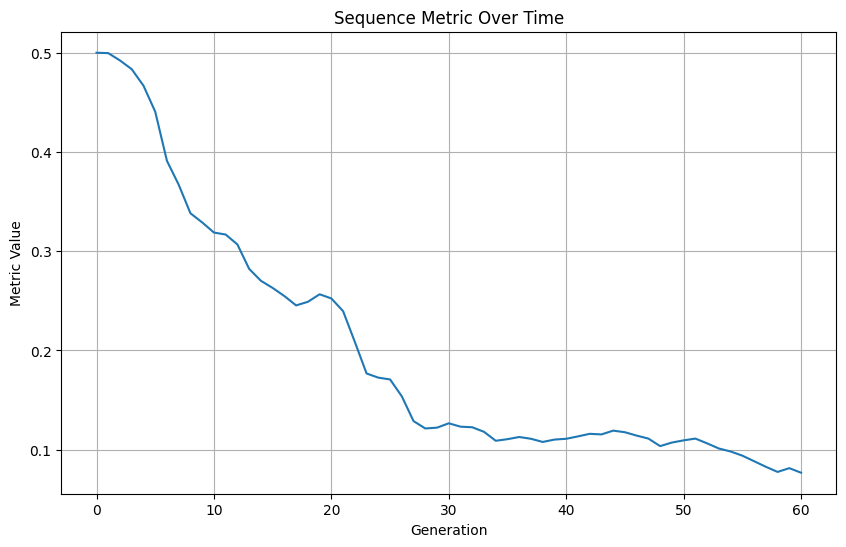

In [3]:
from evo_diffusion.synthetic_sequences import visualize_sequence_metric, average_a_content, gc_content

fig, ax = visualize_sequence_metric(all_sequences, gc_content)

# With selection for 'A', we expect a decrease in GC content. 

## Preparing Data for PyTorch Training

To train a model on sequence evolution, we format the data for PyTorch:

1. Extract Parent-Child Pairs – Link each child sequence to its parent and record the generation time step.
2. One-Hot Encode Sequences – Convert nucleotide sequences into numerical form for model processing.
3. Generate training and test sets for the sequences.
4. Create PyTorch Tensors and DataLoader – Store data as tensors and batch it with a DataLoader for training.

This setup enables neural networks to learn evolutionary patterns from genetic data.

In [4]:
### import numpy as np

def generate_training_pairs(all_sequences, parent_child_indices):
    """
    Generate parent-child training pairs and corresponding time steps using explicit indices.

    Args:
        all_sequences: List of arrays, where each array has shape 
                       (num_sequences, sequence_length) and corresponds to a generation.
        parent_child_indices: List of arrays, where each array has shape (num_sequences,)
                              and indicates the parent index for each child in the next generation.

    Returns:
        parents: Array of parent sequences (num_pairs, sequence_length).
        children: Array of child sequences (num_pairs, sequence_length).
        time_steps: Array of time steps for each pair (num_pairs,).
    """
    parents = []
    children = []
    time_steps = []

    for t in range(len(all_sequences) - 1):
        # Parent generation and child generation
        parent_gen = all_sequences[t]
        child_gen = all_sequences[t + 1]

        # Get the parent-child relationships for this generation
        parent_indices = parent_child_indices[t]

        # Retrieve the parent sequences based on indices
        current_parents = parent_gen[parent_indices]

        # Store parents, children, and time steps
        parents.extend(current_parents)
        children.extend(child_gen)
        time_steps.extend([t + 1] * len(child_gen))  # Time step is t+1 for the child

    # Convert lists to numpy arrays
    parents = np.array(parents)
    children = np.array(children)
    time_steps = np.array(time_steps)

    return parents, children, time_steps

def one_hot_encode(sequences, vocab):
    """
    Convert sequences to one-hot encoding.

    Args:
        sequences: Array of sequences (num_sequences, sequence_length), where each residue
                   is a character (e.g., 'A', 'C', 'G', 'T').
        vocab: List of unique residues (e.g., ['A', 'C', 'G', 'T']).

    Returns:
        one_hot: Array of one-hot encoded sequences (num_sequences, sequence_length, vocab_size).
    """
    # Create a mapping from residues to integer indices
    vocab_size = len(vocab)
    char_to_index = {char: idx for idx, char in enumerate(vocab)}

    # Initialize one-hot encoding array
    num_sequences, sequence_length = sequences.shape
    one_hot = np.zeros((num_sequences, sequence_length, vocab_size), dtype=np.float32)

    # Convert each character to its corresponding index and one-hot encode
    for i in range(num_sequences):
        for j in range(sequence_length):
            residue = sequences[i, j]
            if residue in char_to_index:  # Handle unexpected residues gracefully
                one_hot[i, j, char_to_index[residue]] = 1.0
            else:
                raise ValueError(f"Unexpected residue '{residue}' in sequence.")

    return one_hot

# Define the vocabulary
vocab = ['A', 'C', 'G', 'T']  # Nucleotide bases

parents, children, time_steps = generate_training_pairs(all_sequences, parent_child_indices)
parents_one_hot = one_hot_encode(parents, vocab)
children_one_hot = one_hot_encode(children, vocab)

In [5]:
import sklearn
from sklearn.model_selection import train_test_split

# Split parent-child pairs and time steps
parents_train, parents_val, children_train, children_val, time_train, time_val = train_test_split(
    parents_one_hot, children_one_hot, time_steps, test_size=0.1, random_state=42
)

In [6]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert to PyTorch tensors
parents_train_tensor = torch.tensor(parents_train, dtype=torch.float32)
children_train_tensor = torch.tensor(children_train, dtype=torch.float32)
time_train_tensor = torch.tensor(time_train, dtype=torch.float32)

# Create a PyTorch dataset and dataloader
batch_size = 64
train_dataset = TensorDataset(parents_train_tensor, children_train_tensor, time_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [7]:
parents_train.shape

(5400, 50, 4)

## Training the Diffusion Model

The `DiffusionTrainer` class fits the `EditBasedDiffusion` model to predict how genetic sequences evolve over time. It trains the model to simulate mutations and selection by learning how parent sequences generate offspring and how to reverse this process.

### How the Trainer Works

- The model predicts how parent sequences evolve into children using a forward process.
- It also reconstructs parents from children using a reverse process to enforce consistency.

- Random noise is introduced during training to simulate natural genetic mutations.
- The model learns to apply edits based on these noisy inputs.

### Loss

The model loss is computed for both forward and reverse processes, ensuring the model captures sequence transitions in both directions.
The loss function accounts for mutation-driven randomness while preserving meaningful structure in the sequences.


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

class DiffusionTrainer:
    def __init__(self, model, lr=0.001, alpha=1.0, device="cuda" if torch.cuda.is_available() else "cpu"):
        """
        Trainer class for the EditBasedDiffusion model with time dependency.

        Args:
            model: The diffusion model to train.
            lr: Learning rate for the optimizer.
            alpha: Hyperparameter for mutation weighting.
            device: Device to train on ('cuda' or 'cpu').
        """
        self.model = model.to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.alpha = alpha
        self.device = device

    def compute_mutation_weights(self, parents, children):
        """
        Compute mutation-based weights for all parent-child pairs.

        Args:
            parents: Parent sequences (batch_size, sequence_length).
            children: Child sequences (batch_size, sequence_length).

        Returns:
            weights: Pairwise weight matrix (batch_size, batch_size).
        """
        hamming_distances = (parents != children).sum(dim=-1)
        weights = torch.exp(-self.alpha * hamming_distances)  # Exponential weighting
        return weights

    def compute_loss(self, parents, children, t):
        """
        Compute the weighted loss for the forward and reverse processes with time dependency.

        Args:
            parents: Parent sequences (batch_size, sequence_length, num_residues).
            children: Child sequences (batch_size, sequence_length, num_residues).
            t: Time step tensor (batch_size, 1).

        Returns:
            loss: Weighted loss value.
        """
        # Predict child sequences from parents (forward process)
        noise_forward = torch.randn(parents.shape[0], parents.shape[1], self.model.embedding_dim, device=parents.device)
        forward_field = self.model.forward_edit_field(parents, t, noise_forward)
        predicted_children = self.model.apply_edits(parents, forward_field)

        # Predict parent sequences from children (reverse process)
        noise_reverse = torch.randn(children.shape[0], children.shape[1], self.model.embedding_dim, device=children.device)
        reverse_field = self.model.reverse_edit_field(children, t, noise_reverse)
        predicted_parents = self.model.apply_edits(children, reverse_field)

        # Compute mutation-based weights
        #weights = self.compute_mutation_weights(parents.argmax(dim=-1), children.argmax(dim=-1))

        # Compute loss of forward and reverse networks
        loss_fn = nn.CrossEntropyLoss()
        weighted_loss = loss_fn(torch.log(predicted_children), children) + loss_fn(torch.log(predicted_parents), parents)

        #reg_loss = forward_field.pow(2).sum() + reverse_field.pow(2).sum()
        total_loss = weighted_loss # + 0.01 * reg_loss

        return total_loss

    def train_one_epoch(self, dataloader):
        """
        Train the model for one epoch.

        Args:
            dataloader: DataLoader for training data.

        Returns:
            avg_loss: Average loss for the epoch.
        """
        self.model.train()
        epoch_loss = 0

        for parents, children, t in dataloader:
            # Move data to device
            parents = parents.to(self.device)
            children = children.to(self.device)
            t = t.to(self.device)

            # Zero the gradients
            self.optimizer.zero_grad()

            # Compute loss
            loss = self.compute_loss(parents, children, t)

            # Backpropagation and optimization
            loss.backward()
            self.optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        return avg_loss

    def fit(self, dataloader, epochs=10):
        """
        Train the model for a specified number of epochs.

        Args:
            dataloader: DataLoader for training data.
            epochs: Number of epochs to train.

        Returns:
            loss_history: List of average loss values per epoch.
        """
        loss_history = []
        for epoch in range(epochs):
            avg_loss = self.train_one_epoch(dataloader)
            loss_history.append(avg_loss)
            if epoch % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")
        return loss_history

## EditBasedDiffusion

The `EditBasedDiffusion` model is a bidirectional diffusion model designed for learning sequence evolution. It operates in an embedding space, where forward diffusion models the progression of genetic sequences over time, and reverse diffusion reconstructs ancestral sequences. The model ensures that sampled sequences follow a learned distribution aligned with observed evolutionary transitions.

### Shared Sequence Embedding Network
The model maps discrete sequences to a continuous embedding space using a Transformer-based encoder:  
$$
f_{\text{seq}}: \mathbb{R}^{L \times N} \to \mathbb{R}^{L \times D}
$$
where $L$ is the sequence length, $N$ is the number of possible residues (e.g., \( N=4 \) for DNA bases), and $D$ is the embedding dimension.  

To capture **global sequence-level properties**, a **learnable CLS token** $c \in \mathbb{R}^{1 \times D}$ is prepended, producing:  
$$
S = \text{Concat}(c, f_{\text{seq}}(x)) \in \mathbb{R}^{(L+1) \times D}.
$$  

This sequence embedding provides a structured latent space where evolutionary dynamics can be learned.  

### Temporal Embedding Network
The model encodes time using a sinusoidal embedding:  
$$
f_{\text{time}}: \mathbb{R}^{1} \to \mathbb{R}^{D}.
$$
This produces a **shared temporal representation** \( T \in \mathbb{R}^{B \times D} \) that aligns with the sequence embedding space.  

This enables the model to **condition sequence evolution on time**, allowing it to learn time-dependent selection dynamics.  

### Attention-Based Fusion of Sequence and Time Representations
The sequence and time embeddings are fused using **multi-head attention**, treating  $T$ as the query and \( S \) as key and value:  
$$
\text{Attention}(T, S, S) \in \mathbb{R}^{B \times D}.
$$  
This produces:  
- A **time-aware CLS token** encoding the **global sequence state** conditioned on time.  
- An **updated sequence embedding** where each position is refined using information from the global context.  

This step ensures that both **local sequence features** and **global evolutionary constraints** are incorporated into the learned representation.  

### Stochastic Diffusion Step: Noise Injection and Transition Modeling 
To **model mutations and uncertainty**, the model perturbs the sequence embedding using Gaussian noise:  
$$
S' = S + \eta, \quad \eta \sim \mathcal{N}(0, I)
$$  
where $S'$ represents the **noisy embedding** that serves as input for the next sequence state.  

A **transition function** (implemented via an MLP) then maps this perturbed embedding to an **edit field**:  

$$
e = f_{\text{edit}}(S') \in \mathbb{R}^{L \times N}.
$$  
This edit field represents **probabilities of mutations** at each position in the sequence.  

To **sample new sequences**, we apply a transformation that ensures the output matches the observed training distribution:  
$$
x_t = \operatorname{softmax}(\log(x + \epsilon) + e),
$$
where $\epsilon$ prevents numerical instability.  

This step ensures that generated sequences **maintain realistic evolutionary constraints**, aligning the learned distribution with observed genetic transitions.  

### Forward and Reverse Diffusion Processes
The model operates bidirectionally to simulate sequence evolution:  

- **Forward process**: Given an input sequence $x_t$, predict $x_{t+1}$ by:  
  1. Encoding it into **latent space**.  
  2. Injecting **stochastic noise** to simulate mutations.  
  3. Predicting an **edit field** using a learned transformation.  
  4. Sampling a **new sequence** using the softmax transformation above.  

- **Reverse process**: Given an observed sequence at time $t$, reconstruct its ancestral state $x_{t-1}$ by inverting the transition process.  

This **bidirectional learning** ensures that the model captures **mutation-driven evolution** while preserving **ancestral reconstruction capability**.  

## **How This Relates to Evolution**  
The **EditBasedDiffusion** model simulates **mutation and selection dynamics** by learning a structured latent space where
- **Mutations are modeled as stochastic perturbations** in the embedding space.  
- **Selection is implicitly encoded** through learned edit fields.  
- **Time-dependent constraints** allow adaptation to changing selection pressures.  

In [ ]:
from evo_diffusion.edit_based_diffusion import EditBasedDiffusion

# Initialize the model
embedding_dim = 256
feedforward_dim = 512
transformer_params = {
    "embedding_dim": embedding_dim,
    "num_heads": 8,
    "num_layers": 2,
    "feedforward_dim": feedforward_dim
}

mlp_params = {"feedforward_dim": [feedforward_dim] * 2, "activation": "ReLU"}

model =  EditBasedDiffusion(sequence_length, 4, embedding_dim, transformer_params, mlp_params)

def count_parameters(model):
  total_params = 0
  for param in model.parameters():
    total_params += param.numel()
  return total_params

print(count_parameters(model))

# Initialize the trainer
trainer = DiffusionTrainer(model, lr=4e-4, alpha=0.01)

# Train the model
loss_history = trainer.fit(train_loader, epochs=100)

2137120
Epoch 1/100, Loss: 80.8400


In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_history)

## Evaluating the Model and Generating Predictions

Once the model is trained, we assess its ability to simulate sequence evolution by comparing its predictions to our data. 

### Sampling Sequences from Model Predictions
- Given a probability distribution over possible residues, we sample sequences using multinomial sampling.
- This ensures that generated sequences reflect realistic evolutionary variation.

### Comparing Mutation Rates
- The model’s predicted mutation rates are compared to actual parent-child mutation rates from the simulated data.
- This helps validate whether the model captures realistic patterns of genetic change.

### Simulating Future Generations
- The trained model is used to generate entire populations over multiple generations.
- This allows us to visualize how sequence composition evolves over time, tracking properties of the population like GC content and mean fitness.

In [ ]:
import numpy as np
import torch

def sample_sequence_from_probabilities(probabilities):
    """
    Samples a sequence from predicted probabilities using multinomial sampling.
    
    Args:
        probabilities (torch.Tensor): Predicted probabilities of shape (batch_size, sequence_length, num_residues).

    Returns:
        sampled_indices (torch.Tensor): Sampled residue indices of shape (batch_size, sequence_length).
    """
    batch_size, sequence_length, num_residues = probabilities.shape

    # Flatten the probabilities for sampling
    probabilities_flat = probabilities.view(-1, num_residues)  # (batch_size * sequence_length, num_residues)

    # Sample residue indices for each position
    sampled_indices_flat = torch.multinomial(probabilities_flat, num_samples=1).squeeze(-1)  # (batch_size * sequence_length,)

    # Reshape back to the original sequence format
    sampled_indices = sampled_indices_flat.view(batch_size, sequence_length)  # (batch_size, sequence_length)

    return sampled_indices

def map_indices_to_strings_numpy(indices, vocab):
    """
    Map sequence indices back to their string representations and return as a NumPy array.

    Args:
        indices: Array or tensor of shape (batch_size, sequence_length).
        vocab: List or array of string representations (e.g., ['A', 'C', 'G', 'T']).

    Returns:
        mapped_sequences: NumPy array of shape (batch_size, sequence_length), where each element
                          is the string representation of the corresponding index.
    """
    if isinstance(indices, torch.Tensor):
        indices = indices.numpy()  # Convert tensor to numpy array if necessary

    # Create a vectorized function to map indices to strings
    vectorized_mapping = np.vectorize(lambda idx: vocab[idx])

    # Apply the mapping
    mapped_sequences = vectorized_mapping(indices)

    return mapped_sequences

## Comparing mutation rates

In [ ]:
import matplotlib.pyplot as plt


def plot_mutation_rate_comparison(all_sequences, parent_child_indices, model, time_steps):
    """
    Compare the mutation rates between actual parent-child pairs and model-predicted pairs.

    Args:
        all_sequences: List of actual sequences over time steps.
        parent_child_indices: List of parent-child indices for each generation.
        model: Trained diffusion model.
        time_steps: List of time steps to evaluate.
    """
    actual_mutation_rates = []
    predicted_mutation_rates = []

    for t in time_steps:
        parent_gen = all_sequences[t - 1]
        child_gen = all_sequences[t]
        parent_indices = parent_child_indices[t - 1]

        # Actual parent-child pairs
        actual_parents = parent_gen[parent_indices]
        actual_children = child_gen

        # Predict child sequences using the model
        actual_parents_one_hot = torch.tensor(one_hot_encode(actual_parents, vocab))

        t_tensor = torch.tensor([[t]] * len(actual_parents)).float()
        t_tensor = t_tensor[:, 0]

        predicted_children_onehot = model.forward(actual_parents_one_hot, t_tensor)
        predicted_children = predicted_children_onehot.argmax(dim=-1)
        predicted_children = sample_sequence_from_probabilities(predicted_children_onehot)

        # Compute actual mutation rate
        actual_mutations = (actual_parents != actual_children).sum()
        actual_mutation_rate = actual_mutations / actual_parents.shape[0]
        actual_mutation_rates.append(actual_mutation_rate)

        # Compute predicted mutation rate
        predicted_children = map_indices_to_strings_numpy(predicted_children, vocab)
        predicted_mutations = (actual_parents != predicted_children).sum().item()
        predicted_mutation_rate = predicted_mutations / actual_parents.shape[0]
        predicted_mutation_rates.append(predicted_mutation_rate)

    # Plot mutation rates
    plt.figure(figsize=(8, 6))
    plt.plot(time_steps, actual_mutation_rates, label="Actual Mutation Rate", marker="o")
    plt.plot(time_steps, predicted_mutation_rates, label="Predicted Mutation Rate", marker="x")
    plt.axhline( mutation_rate * sequence_length, label="Theoretical mutation rate")
    plt.xlabel("Time Step")
    plt.ylabel("Mutation Rate")
    plt.title("Comparison of Mutation Rates Over Time (Parent-Child)")
    plt.legend()
    plt.grid()
    plt.show()

time_steps = range(1, len(all_sequences))  # Exclude the initial sequence
plot_mutation_rate_comparison(all_sequences, parent_child_indices, model, time_steps)

## One-step evolution comparison

In [ ]:
def plot_sequence_evolution_comparison(all_sequences, parent_child_indices, model, vocab, num_samples=5):
    """
    Compare sequence evolution between actual and model-predicted sequences.

    Args:
        all_sequences: List of arrays, where each array contains sequences for one generation.
        parent_child_indices: List of arrays, where each array maps parent indices to children.
        model: Trained diffusion model with a forward method.
        vocab: List of characters representing the sequence alphabet (e.g., ['A', 'C', 'G', 'T']).
        num_samples: Number of sequences to sample for comparison.
    """
    time_steps = len(all_sequences) - 1  # Number of generations
    sample_indices = np.random.choice(len(all_sequences[0]), num_samples, replace=False)  # Sample sequences

    actual_sequences = []
    predicted_sequences = []

    for idx in sample_indices:
        actual_sample_sequence = []
        predicted_sample_sequence = []

        # Initialize the current sequence with one-hot encoding
        #current_sequence = all_sequences[0][idx]  # Integer-encoded sequence
        #current_sequence_one_hot = torch.tensor(one_hot_encode(current_sequence[None, :], vocab), dtype=torch.float32)

        # Track actual and predicted sequences over time
        for t in range(1, time_steps + 1):
            parent_gen = all_sequences[t - 1]
            child_gen = all_sequences[t]
            parent_indices = parent_child_indices[t - 1]

            # Actual parent-child pair
            actual_parent = parent_gen[parent_indices[idx]]
            actual_child = child_gen[idx]

            current_sequence_one_hot = torch.tensor(one_hot_encode(parent_gen, vocab), dtype=torch.float32)

            # Predict child sequence
            t_tensor = torch.tensor([[t]] * parent_gen.shape[0], dtype=torch.float32)  # Time tensor
            predicted_child_one_hot = model.forward(current_sequence_one_hot, t_tensor[:,0])
            predicted_child = predicted_child_one_hot.argmax(dim=-1).numpy()
            predicted_child = sample_sequence_from_probabilities(predicted_child_one_hot)
            
            # Store actual and predicted sequences
            actual_sample_sequence.append(actual_child)
            predicted_sample_sequence.append(predicted_child)

            # Update the current sequence for the next step
            #current_sequence_one_hot = predicted_child_one_hot

        actual_sequences.append(np.array(actual_sample_sequence))
        predicted_sequences.append(np.array(predicted_sample_sequence))


    # Plot evolution using numerical indices for heatmaps
    plt.figure(figsize=(12, 12))
    vocab_map = {'A':0, 'C':1, 'G':2, 'T':3}
    for i in range(num_samples):
        # Convert sequences to integer arrays for visualization
        actual_sequence_numeric = np.array([[vocab_map[str(char)] for char in seq] for seq in actual_sequences[i]])
        predicted_sequence_numeric = predicted_sequences[i][:,0,:]

        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(actual_sequence_numeric, aspect="auto", cmap="viridis")
        plt.colorbar(label="Residue Index")
        plt.ylabel("Time Step")
        plt.title(f"Sample {i + 1} Actual Evolution")

        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.imshow(predicted_sequence_numeric, aspect="auto", cmap="viridis")
        plt.colorbar(label="Residue Index")
        plt.ylabel("Time Step")
        plt.title(f"Sample {i + 1} Predicted Evolution")

    plt.xlabel("Sequence Position")
    plt.tight_layout()
    plt.show()
plot_sequence_evolution_comparison(all_sequences, parent_child_indices, model, vocab, num_samples=5)

## Visualizing sequence embeddings

In [ ]:
# Import necessary libraries
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch

# Function to subsample the tensors for PCA analysis
def subsample_tensors(parents_tensor, children_tensor, times_tensor, sample_size=100):
    """
    Subsample the parent-child tensors and their corresponding times.

    Args:
        parents_tensor: Tensor of parent sequences (batch_size, sequence_length, num_residues).
        children_tensor: Tensor of child sequences (batch_size, sequence_length, num_residues).
        times_tensor: Tensor of time steps corresponding to the sequences (batch_size, 1).
        sample_size: Number of samples to subsample.

    Returns:
        sequences: Subsampled tensor of sequences.
        times: Subsampled tensor of times.
    """
    indices = torch.randperm(parents_tensor.size(0))[:sample_size]
    sequences = torch.cat((parents_tensor[indices], children_tensor[indices]), dim=0)
    times = torch.cat((times_tensor[indices], times_tensor[indices]), dim=0)
    return sequences, times

def get_time_aware_cls(model, x, fixed_time):
    """
    Get the time-aware CLS token for a fixed time.

    Args:
        x (torch.Tensor): Input sequence (batch_size, sequence_length, num_residues).
        fixed_time (float): A fixed time value to compute the time embedding.

    Returns:
        time_aware_cls (torch.Tensor): Time-aware CLS token (batch_size, embedding_dim).
    """
    # Convert the fixed time to a tensor
    batch_size = x.size(0)
    t_tensor = torch.tensor([fixed_time] * batch_size, device=x.device, dtype=torch.float32)  # (batch_size, 1)

    # Embed sequence and add CLS token
    seq_with_cls = model.embed_sequence(x)  # (batch_size, sequence_length + 1, embedding_dim)

    # Embed the fixed time
    time_embedding = model.embed_time(t_tensor)
    print(time_embedding.shape)

    # Combine embeddings using attention to get the time-aware CLS token
    time_aware_cls, _ = model.combine_embeddings(seq_with_cls, time_embedding, model.forward_attention)

    return time_aware_cls
    
# PCA plotting function using the model's `embed_sequence`
def plot_pca_of_embeddings(model, sequences, times, num_components=2):
    """
    Perform PCA on the embeddings generated by the model using `embed_sequence` and plot them.

    Args:
        model: The trained diffusion model with the `embed_sequence` method.
        sequences: Input sequences as one-hot tensors (batch_size, sequence_length, num_residues).
        times: Sampling times corresponding to each sequence (batch_size, 1).
        num_components: Number of principal components to compute (default: 2).
    """
    # Generate embeddings using the model's `embed_sequence` method
    #embeddings = model.embed_sequence(sequences).detach().cpu().numpy()  # Shape: (batch_size, embedding_dim)
    embeddings = get_time_aware_cls(model, sequences, 0).detach().cpu().numpy()
    print(embeddings.shape)
    embeddings = embeddings[:, :]
    
    # Perform PCA
    pca = PCA(n_components=num_components)
    principal_components = pca.fit_transform(embeddings)

    # Variance explained by each principal component
    explained_variance = pca.explained_variance_ratio_ * 100

    # Plot PCA
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        principal_components[:, 0],
        principal_components[:, 1],
        c=times.squeeze().numpy(),  # Use sampling times for coloring
        cmap="viridis",
        edgecolor="k",
        alpha=0.8
    )
    plt.colorbar(scatter, label="Time of Sampling")
    plt.xlabel(f"PC1 ({explained_variance[0]:.2f}% Variance Explained)")
    plt.ylabel(f"PC2 ({explained_variance[1]:.2f}% Variance Explained)")
    plt.title("PCA of Model Embeddings Colored by Sampling Time")
    plt.grid(True)
    plt.show()

# Example usage with subsampled data
sample_size = 500  # Adjust based on your dataset size

# Subsample the tensors
sequences, times = subsample_tensors(parents_train_tensor, children_train_tensor, time_train_tensor, sample_size)

# Plot PCA
plot_pca_of_embeddings(model, sequences, times)

## Sampling population trajectories

In [ ]:
def sample_forward(model, x_0, t_target):
    """
    Efficiently sample sequences forward in time to t_target.

    Args:
        model: The diffusion model.
        x_0: Base sequence (batch_size, sequence_length, num_residues).
        t_target: Target time to evolve the sequence to.

    Returns:
        x_t: Sequence evolved to time t_target.
    """
    # Create time tensor for t_target
    t = torch.tensor([[t_target]] * x_0.size(0), device=x_0.device, dtype=torch.float32)
    
    # Generate edit field for the target time
    #edit_field = model.forward_edit_field(x_0, t)
    
    # Apply edits to evolve sequences to the target time
    #x_t = model.apply_edits(x_0, edit_field)
    x_t = model.forward(x_0, t[:,0])
    return sample_sequence_from_probabilities(x_t)


def generate_population(model, all_sequences, num_generations, batch_size):
    """
    Generate replicate populations across generations using the model efficiently.

    Args:
        model: The trained diffusion model.
        all_sequences: Initial sequences for the population (generation 0).
        num_generations: Number of generations to simulate.
        batch_size: Number of sequences in each batch.

    Returns:
        replicate_populations: List of sequences for each generation.
    """
    # Initialize the first generation
    x_0 = torch.tensor(one_hot_encode(all_sequences[0], vocab), dtype=torch.float32)
    replicate_populations = [all_sequences[0]]  # Store all generations

    current_population = x_0.clone()  # Start with the initial population

    for gen in range(num_generations):
        # Randomly sample a batch from the current population
        sampled_indices = np.random.choice(current_population.size(0), batch_size, replace=False)
        x_start = current_population[sampled_indices]

        # Evolve the sampled batch to the next generation
        x_next = sample_forward(model, x_start, t_target=gen+1)  # Move forward by 1 generation

        # Store the new generation
        x_next_seq = map_indices_to_strings_numpy(x_next.detach(), vocab)
        replicate_populations.append(x_next_seq)

        # Update current population for the next iteration
        current_population = torch.tensor(one_hot_encode(x_next_seq, vocab), dtype=torch.float32)
        #current_population = torch.tensor(one_hot_encode(all_sequences[gen+1], vocab), dtype=torch.float32)

    return replicate_populations

In [ ]:
# Generate populations for all generations
replicate_populations = generate_population(
    model=model,
    all_sequences=all_sequences,
    num_generations=time_span,
    batch_size=20,
)

In [ ]:
# Convert to NumPy arrays for further analysis
replicate_populations_np = [x for x in replicate_populations]

In [ ]:
from evo_diffusion.synthetic_sequences import visualize_sequence_metric, average_a_content, gc_content

fig, ax = visualize_sequence_metric(all_sequences, gc_content)
visualize_sequence_metric(replicate_populations_np, gc_content, ax=ax,  title="GC Content Over Time")

plt.tight_layout()
plt.show()

def mean_fitness(population, generation):
    return example_fitness_function(population, generation).mean()

fig, ax = visualize_sequence_metric(all_sequences, mean_fitness, time_dependent_metric=True)
visualize_sequence_metric(replicate_populations_np, mean_fitness, ax=ax,  title="Mean fitness", time_dependent_metric=True)

plt.tight_layout()
plt.show()